In [2]:
!pip install torch==1.8.0+cpu torchvision==0.9.0+cpu torchaudio===0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [5]:

# Here we import everything we need for the project

#%matplotlib inline
#from google.colab import files
import os

# TensorFlow and tf.keras
#import tensorflow as tf
#from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
#import cv2
import pandas as pd
import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
import glob

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
#from sklearn.metrics import confusion_matrix # Helps present results as a confusion-matrix

#print(tf.__version__)

In [10]:
imagepaths = []

# Go through all the files and subdirectories inside a folder and save path to images inside list
for root, dirs, files in os.walk(".", topdown=False): 
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("csv"): # We want only the images
      imagepaths.append(path)

print(len(imagepaths)) # If > 0, then a PNG image was loaded

device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

1673


In [93]:
def plot_image(path):
    data = pd.read_csv(path,header=None)
    ii = data.iloc[:,:138]
    qq = data.iloc[:,138:]
    complexqq = qq*1j
    iq = ii.add(complexqq, fill_value=0)
    plt.figure(figsize = (100,100))
    plt.imshow(abs(iq),aspect ='0.5' ,extent=[0,40,0,1200])
    #plt.xlim([0, 40])
    plt.xlabel("Fast time")
    plt.ylabel("Slow time")
    plt.title("Image " + path)

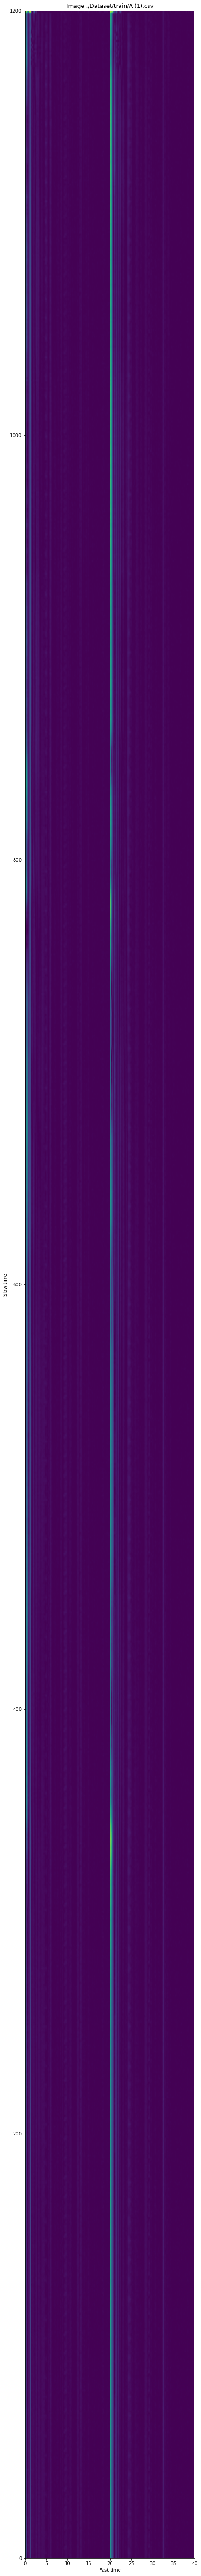

In [94]:
plot_image('./Dataset/train/A (1).csv')

In [6]:

class Dataset_Interpreter(Dataset):
    def __init__(self,file_names, transforms=None):
        self.file_names = file_names
        self.transforms = transforms

    def __len__(self):
        return (len(self.file_names))

    def __getitem__(self,idx):
        data = pd.read_csv(self.file_names[idx])
        ii = data.iloc[250:1100,:138]
        qq = data.iloc[250:1100,138:276]
        complexqq = qq.astype(float)*1j
        iq = ii.add(complexqq, fill_value=0)
        X =abs(iq)
        Y= 3
        if(os.path.basename(self.file_names[idx]).startswith('A')):
            Y = 0
        elif(os.path.basename(self.file_names[idx]).startswith('B')):
            Y = 1
        elif(os.path.basename(self.file_names[idx]).startswith('')):
            Y = 2
    
        X_array = np.array(X,dtype='float')
        
        dataset_X = torch.FloatTensor(X_array)
        dataset_X = dataset_X.unsqueeze(2) #so that the format is accepted for eg. [50, 600, 276] --> [50, 1, 600, 276]
        dataset_Y = torch.tensor(Y,dtype=torch.long)
        
        #pdb.set_trace() 
        if self.transforms is not None:
            dataset_X = self.transforms(dataset_X)   
        return dataset_X,dataset_Y
    
training_path='./Dataset/train/'
training_filename = glob.glob(training_path + '*.csv')    
mytransform = torchvision.transforms.RandomAffine(
    degrees= 90, 
    #translate=(0.25, 0.5), 
    scale=(1.2, 2.0), 
   # shear=0.1
)
train_data = Dataset_Interpreter(file_names=training_filename ,transforms=None)


In [171]:
it = iter(train_data)
for x in range (100):
    first = next(it)

#plt.imshow(train_data[0],aspect ='0.5' ,extent=[0,40,0,1200])


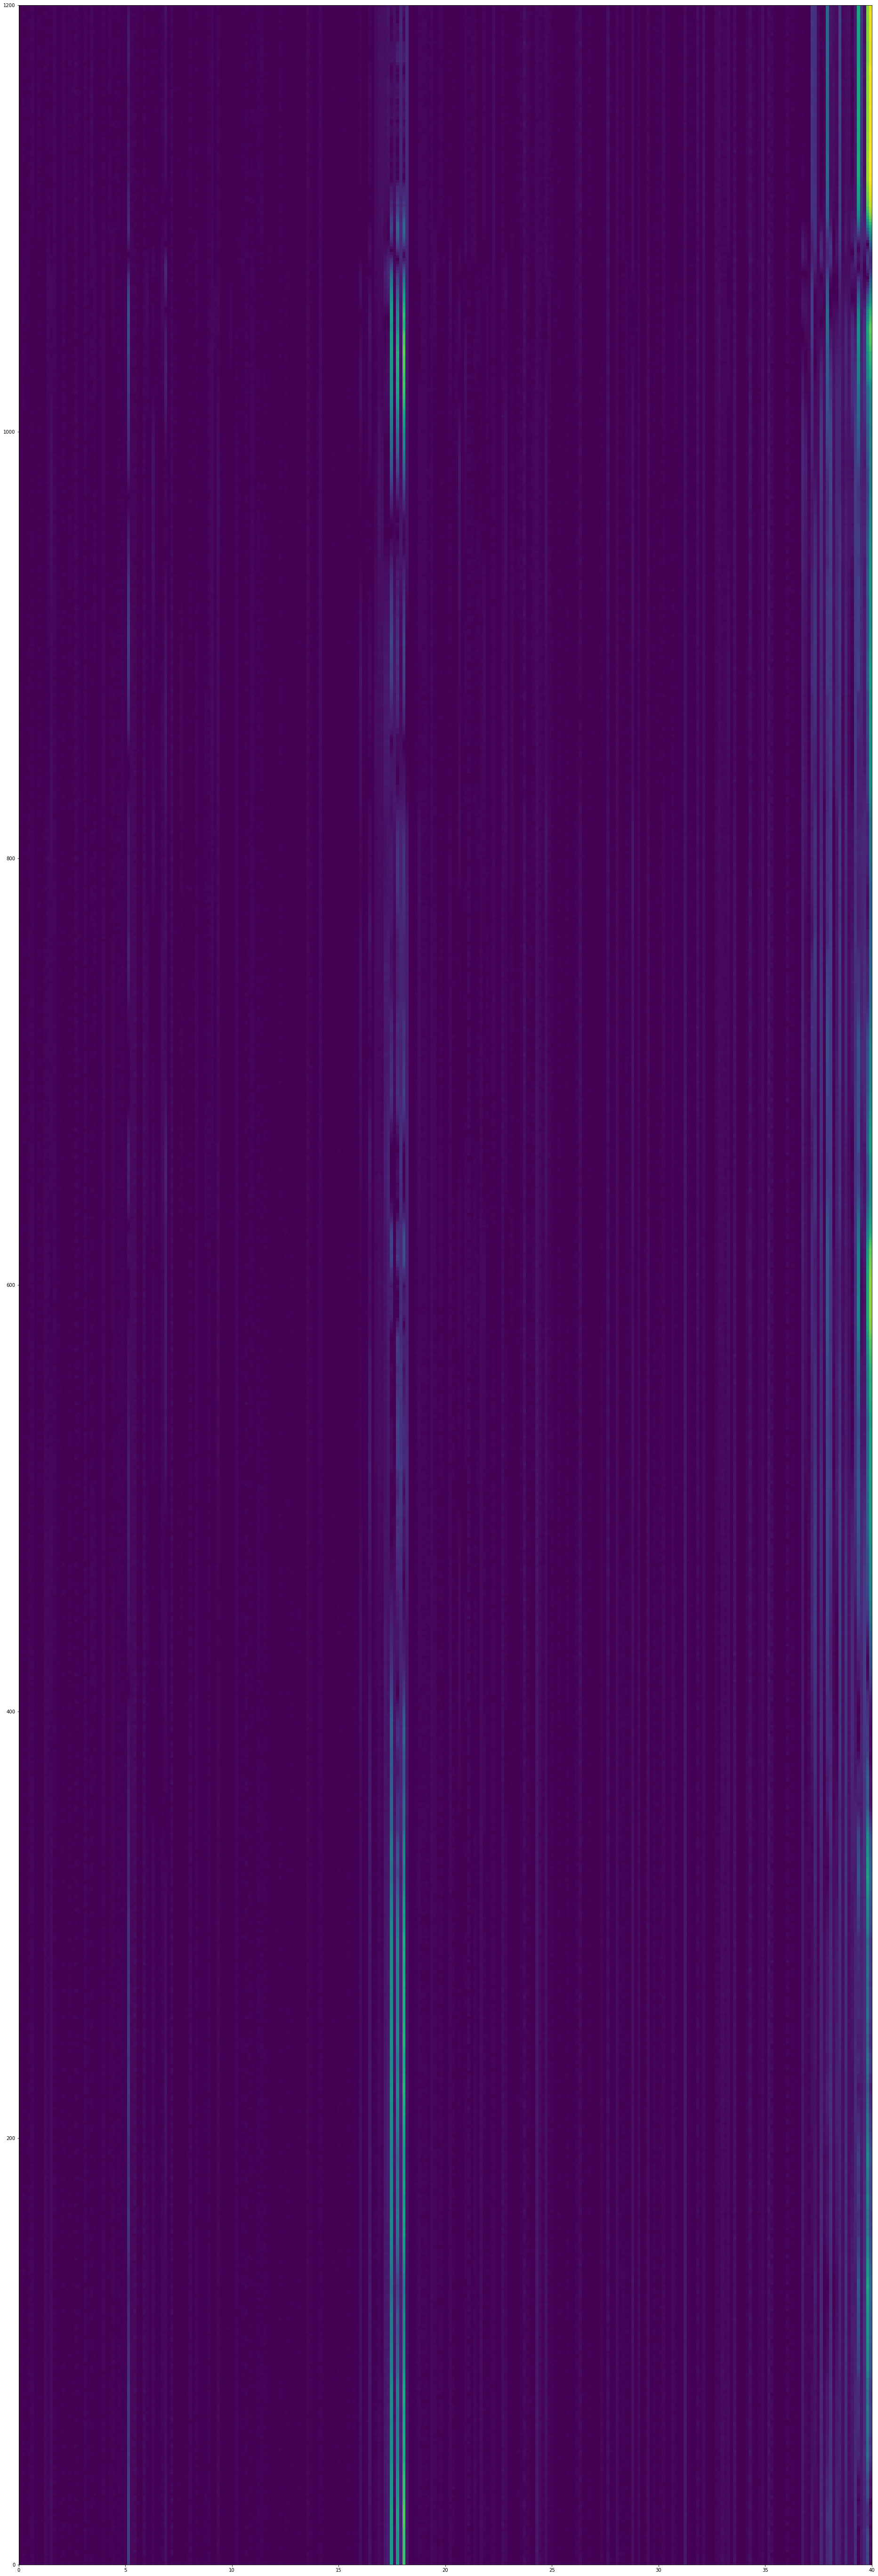

In [172]:
plt.figure(figsize = (100,100))
plt.imshow(first[0],aspect ='0.1' ,extent=[0,40,0,1200])

In [42]:
import torch.nn as nn
import torch.nn.functional as F

simple_model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=5),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(32, 64, kernel_size=5),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Flatten(), 
    nn.Linear(54*144*63, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 2)
)


out = simple_model(X_train.float())
print('out.shape:', out.shape)
    

out.shape: torch.Size([45, 64, 144, 63])


In [63]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))
        #self.drop_out = nn.Dropout()
        self.fc1 = nn.Flatten
        self.fc2 = nn.Linear(54*144*63, 1024)   
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

In [64]:
model = ConvNet()
out = model(X_train.float())
print('out.shape:', out.shape)
print('out[0]:', out[0])

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:73] data. DefaultCPUAllocator: not enough memory: you tried to allocate 933765120 bytes. Buy new RAM!